<a href="https://colab.research.google.com/github/ABD-01/MNIST/blob/main/Multi%20Layer%20Model/MNIST_Using_Multi_Layer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install idx2numpy

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import idx2numpy
from tqdm import tqdm
import pandas as pd

In [ ]:
!wget https://github.com/ABD-01/MNIST/raw/main/t10k-images.idx3-ubyte
!wget https://github.com/ABD-01/MNIST/raw/main/t10k-labels.idx1-ubyte
!wget https://github.com/ABD-01/MNIST/raw/main/train-images.idx3-ubyte
!wget https://github.com/ABD-01/MNIST/raw/main/train-labels.idx1-ubyte

In [ ]:
test_images = idx2numpy.convert_from_file('t10k-images.idx3-ubyte')
test_labels = idx2numpy.convert_from_file('t10k-labels.idx1-ubyte')
train_images = idx2numpy.convert_from_file('train-images.idx3-ubyte')
train_labels = idx2numpy.convert_from_file('train-labels.idx1-ubyte')

In [ ]:
print(test_images.shape)
print(test_labels.shape)
print(train_images.shape)
print(train_labels.shape)

(10000, 28, 28)
(10000,)
(60000, 28, 28)
(60000,)


In [ ]:
train_images_flat=train_images.reshape(train_images.shape[0], -1).T
test_images_flat=test_images.reshape(test_images.shape[0], -1).T

In [ ]:
m = train_images_flat.shape[1]
m_test = test_images_flat.shape[1]
print(f"Train Examples(m)={m}")
print(f"Test Examples(m_test)={m_test}")
X = train_images_flat/255
X_test = test_images_flat/255
print('X.shape=',X.shape)
print('X_test.shape=',X_test.shape)

Train Examples(m)=60000
Test Examples(m_test)=10000
X.shape= (784, 60000)
X_test.shape= (784, 10000)


In [ ]:
def one_hot(row_vector, no_classes):
    one_hot_vector = np.eye(no_classes)[row_vector.reshape(-1)]
    return one_hot_vector.T

In [ ]:
C = train_labels.max()+1
print(f"No. of Classes={C}")
Y_hot = one_hot(train_labels,no_classes=C)
Y_test_hot = one_hot(test_labels,no_classes=C)
print('Y_hot.shape=',Y_hot.shape) #Y_hot.shape is (C,m)
print('Y_test_hot.shape=',Y_test_hot.shape) #Y_hot.shape is (C,m)

No. of Classes=10
Y_hot.shape= (10, 60000)
Y_test_hot.shape= (10, 10000)


In [ ]:
no_of_layers = 4
nodes = [X.shape[0], 512, 128, 32, 10]   # 4 layers with size 512, 128, 32, 10
nodes

[784, 512, 128, 32, 10]

In [ ]:
def initialize():
  global WW, bb
  WW = {}
  bb = {}
  for l in range(1,no_of_layers+1):
    WW['W'+str(l)] = np.random.randn(nodes[l], nodes[l-1])*np.sqrt(2/nodes[l-1])
    bb['b'+str(l)] = np.zeros((nodes[l],1))

In [ ]:
list(range(1,no_of_layers+1))

[1, 2, 3, 4]

In [ ]:
initialize()

In [ ]:
WW['W1'].shape, WW['W2'].shape,WW['W3'].shape, WW['W4'].shape

((512, 784), (128, 512), (32, 128), (10, 32))

In [ ]:
bb['b1'].shape, bb['b2'].shape,bb['b3'].shape, bb['b4'].shape

((512, 1), (128, 1), (32, 1), (10, 1))

In [ ]:
def relu(z):
  a = np.maximum(0,z)
  return a

def softmax(z):
  t = np.exp(z)
  a = t / (np.sum(t, keepdims=True, axis=0))
  return a  #+ 1e-08

def derivative_relu(da,z):
  dz = np.array(da, copy=True)
  dz[z<=0] = 0
  dz[z>0] = 1
  return dz


In [ ]:
def forward():
  global ZZ, AA
  ZZ={}
  AA={}
  AA['A'+str(0)] = X
  for l in range(1,no_of_layers):
    ZZ['Z'+str(l)] = np.dot(WW['W'+str(l)], AA['A'+str(l-1)]) +  bb['b'+str(l)]
    AA['A'+str(l)] = relu(ZZ['Z'+str(l)])

  ZZ['Z'+str(no_of_layers)] = np.dot(WW['W'+str(no_of_layers)], AA['A'+str(no_of_layers-1)]) +  bb['b'+str(no_of_layers)]
  AA['A'+str(no_of_layers)] = softmax(ZZ['Z'+str(no_of_layers)])

In [ ]:
forward()

In [ ]:
[(z[0],z[1].shape) for z in ZZ.items()], [(a[0],a[1].shape) for a in AA.items()]

([('Z1', (512, 60000)),
  ('Z2', (128, 60000)),
  ('Z3', (32, 60000)),
  ('Z4', (10, 60000))],
 [('A0', (784, 60000)),
  ('A1', (512, 60000)),
  ('A2', (128, 60000)),
  ('A3', (32, 60000)),
  ('A4', (10, 60000))])

In [ ]:
def cost():
  global L,J
  L = -np.sum(Y_hot*np.log(AA['A'+str(no_of_layers)]), keepdims=True, axis=0)
  J = np.sum(L, keepdims=True, axis=1)*(1/m)
  # J = -np.sum(Y_hot*np.log(AA['A'+str(no_of_layers)]), keepdims=True) / m

In [ ]:
cost()

In [ ]:
L.shape , J.shape

((1, 60000), (1, 1))

In [ ]:
def backward():
  global dAA, dZZ, dWW, dbb
  dAA = {}
  dZZ = {}
  dWW = {}
  dbb = {}
  dZZ['dZ'+str(no_of_layers)] = AA['A'+str(no_of_layers)] - Y_hot
  dWW['dW'+str(no_of_layers)] = np.dot(dZZ['dZ'+str(no_of_layers)], AA['A'+str(no_of_layers-1)].T) / m
  dbb['db'+str(no_of_layers)] = np.sum(dZZ['dZ'+str(no_of_layers)], axis=1, keepdims=True) / m
  dAA['dA'+str(no_of_layers-1)] = np.dot(WW['W'+str(no_of_layers)].T, dZZ['dZ'+str(no_of_layers)])

  for l in range(no_of_layers-1,0,-1):
    dZZ['dZ'+str(l)] = np.multiply(dAA['dA'+str(l)] , derivative_relu(dAA['dA'+str(l)], ZZ['Z'+str(l)]))
    dWW['dW'+str(l)] = np.dot(dZZ['dZ'+str(l)], AA['A'+str(l-1)].T) / m
    dbb['db'+str(l)] = np.sum(dZZ['dZ'+str(l)], axis=1, keepdims=True) / m
    dAA['dA'+str(l-1)] = np.dot(WW['W'+str(l)].T, dZZ['dZ'+str(l)])

In [ ]:
backward()

In [ ]:
[(dz[0],dz[1].shape) for dz in dZZ.items()], [(da[0],da[1].shape) for da in dAA.items()]

([('dZ4', (10, 60000)),
  ('dZ3', (32, 60000)),
  ('dZ2', (128, 60000)),
  ('dZ1', (512, 60000))],
 [('dA3', (32, 60000)),
  ('dA2', (128, 60000)),
  ('dA1', (512, 60000)),
  ('dA0', (784, 60000))])

In [ ]:
[(dw[0],dw[1].shape) for dw in dWW.items()], [(db[0],db[1].shape) for db in dbb.items()]

([('dW4', (10, 32)),
  ('dW3', (32, 128)),
  ('dW2', (128, 512)),
  ('dW1', (512, 784))],
 [('db4', (10, 1)), ('db3', (32, 1)), ('db2', (128, 1)), ('db1', (512, 1))])

In [ ]:
initialize()

In [ ]:
#optimise
alpha = 0.11
iterations = 1000
global costs
costs=[]
for i in range(iterations):
    forward()
    if i%4 ==0:
      cost()
      costs.append(J)
      print(f'Cost at {i}th loop = {J}')
    backward()
    for l in range(1,no_of_layers+1):
      WW['W'+str(l)] = WW['W'+str(l)] - (alpha*dWW['dW'+str(l)])
      bb['b'+str(l)] = bb['b'+str(l)] - (alpha*dbb['db'+str(l)])

Cost at 0th loop = [[2.36484472]]
Cost at 4th loop = [[2.01051556]]
Cost at 8th loop = [[1.67912192]]
Cost at 12th loop = [[1.31578452]]
Cost at 16th loop = [[1.75320285]]
Cost at 20th loop = [[0.95061448]]
Cost at 24th loop = [[1.03564894]]
Cost at 28th loop = [[0.7562739]]
Cost at 32th loop = [[0.70137146]]
Cost at 36th loop = [[0.62247438]]
Cost at 40th loop = [[0.59295722]]
Cost at 44th loop = [[0.55479752]]
Cost at 48th loop = [[0.48481893]]
Cost at 52th loop = [[0.44434587]]
Cost at 56th loop = [[0.43351902]]
Cost at 60th loop = [[0.52332695]]
Cost at 64th loop = [[0.49213975]]
Cost at 68th loop = [[0.38295426]]
Cost at 72th loop = [[0.3646384]]
Cost at 76th loop = [[0.3529582]]
Cost at 80th loop = [[0.34395951]]
Cost at 84th loop = [[0.33678121]]
Cost at 88th loop = [[0.33154]]
Cost at 92th loop = [[0.3291225]]
Cost at 96th loop = [[0.33084058]]
Cost at 100th loop = [[0.33297214]]
Cost at 104th loop = [[0.32549666]]
Cost at 108th loop = [[0.31189783]]
Cost at 112th loop = [[0.30

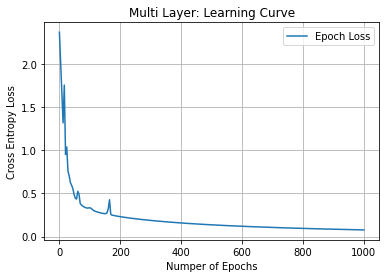

In [3]:
plt.plot(np.linespace(0,1000,len(costs)), np.array(costs).reshape(len(costs),1), label="Epoch Loss")
plt.grid()
plt.title("Multi Layer: Learning Curve")
plt.legend()
plt.xlabel("Numper of Epochs")
plt.ylabel("Cross Entropy Loss")
plt.savefig("/content/drive/MyDrive/Colab Notebooks/MultiCost.jpeg")
plt.show()

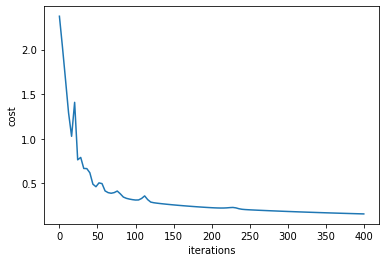

In [ ]:
plt.plot(np.arange(0,401,4), np.array(costs).reshape(len(costs),1))
plt.ylabel('cost')
plt.xlabel('iterations')
cimg = plt.show()

In [ ]:
a = np.abs(AA['A4']- Y_hot)
print(f'Accuracy : {100 - np.mean(a)*100} on Train Set')

Accuracy : 98.27236926433604 on Train Set


In [ ]:
O = (np.max(AA['A4'],axis=0) == AA['A4']).T * np.array([0,1,2,3,4,5,6,7,8,9]).T

F = np.sum(O,axis=1)
F,train_labels

print(f'{np.sum(F==train_labels)} images correctly labeled out of {train_labels.shape[0]} for Train Set')

57291 images correctly labeled out of 60000 for Train Set


In [ ]:
# test
ZZ_test={}
AA_test={}
AA_test['A'+str(0)] = X_test
for l in range(1,no_of_layers):
  ZZ_test['Z'+str(l)] = np.dot(WW['W'+str(l)], AA_test['A'+str(l-1)]) +  bb['b'+str(l)]
  AA_test['A'+str(l)] = relu(ZZ_test['Z'+str(l)])

ZZ_test['Z'+str(no_of_layers)] = np.dot(WW['W'+str(no_of_layers)], AA_test['A'+str(no_of_layers-1)]) +  bb['b'+str(no_of_layers)]
AA_test['A'+str(no_of_layers)] = softmax(ZZ_test['Z'+str(no_of_layers)])

In [ ]:
O = (np.max(AA_test['A4'],axis=0) == AA_test['A4']).T * np.array([0,1,2,3,4,5,6,7,8,9]).T

F_test = np.sum(O,axis=1)
F_test,train_labels

print(f'{np.sum(F_test==test_labels)} images correctly labeled out of {test_labels.shape[0]} for Test Set')

9505 images correctly labeled out of 10000 for Test Set


In [ ]:
a_test = np.abs(AA_test['A4']- Y_test_hot)
print(f'Accuracy : {100 - np.mean(a_test)*100} on Test Set')

Accuracy : 98.25963568404327 on Test Set


The image no. is 3 and my Model predicts 2


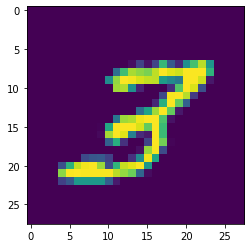

In [ ]:
image = 9925   # 0-9999
plt.imshow(test_images[image])
print(f'The image no. is {test_labels[image]} and my Model predicts {F_test[image]}')